In [1]:
import pandas as pd
from pymatgen.core import Composition
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rho_plus as rp

theme, cs = rp.mpl_setup(False)

In [2]:
import json

with open('datasets/steels_yield.json') as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(**data)
df

,composition,yield strength
0,Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110N...,2411.5
1,Fe0.623C0.00854Mn0.000104Si0.000203Cr0.147Ni0....,1123.1
2,Fe0.625Mn0.000102Si0.000200Cr0.0936Ni0.129Mo0....,1736.3
3,Fe0.634C0.000478Mn0.000523Si0.00102Cr0.000111N...,2487.3
4,Fe0.636C0.000474Mn0.000518Si0.00101Cr0.000109N...,2249.6
...,...,...
307,Fe0.823C0.0176Mn0.00183Si0.000198Cr0.0779Ni0.0...,1722.5
308,Fe0.823Mn0.000618Si0.00101Cr0.0561Ni0.0984Mo0....,1019.0
309,Fe0.825C0.0174Mn0.00175Si0.000201Cr0.0565Ni0.0...,1860.3
310,Fe0.858C0.0191Mn0.00194Si0.000199Cr0.0753Ni0.0...,1812.1


In [4]:
comps: list[Composition] = [Composition(x) for x in df['composition']]
comps[0]

Composition('Fe0.62 C0.000953 Mn0.000521 Si0.00102 Cr0.00011 Ni0.192 Mo0.0176 V0.000112 Nb6.16e-05 Co0.146 Al0.00318 Ti0.0185')

<Axes: ylabel='Frequency'>

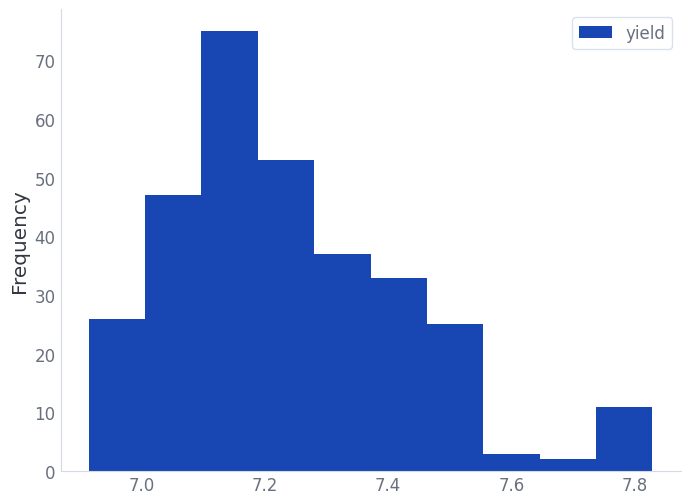

In [5]:
elems = list({c.symbol for c in set.union(*[set(c.elements) for c in comps])})

fracs = []

for comp in comps:
    base = {e: 0 for e in elems}
    base.update(comp.get_el_amt_dict())
    fracs.append(base)

fdf = pd.DataFrame(fracs)
fdf['yield'] = df['yield strength']
fdf['yield'] = np.log(df['yield strength'] + 1)
fdf[['yield']].plot.hist()

In [6]:
fdf.to_feather('datasets/steels_raw.feather')

In [8]:
import matminer

from matminer.featurizers.base import MultipleFeaturizer
import matminer.featurizers.composition as cf

preset = cf.ElementProperty.from_preset('magpie')
megnet = cf.ElementProperty.from_preset('megnet_el')

feats = MultipleFeaturizer([
    cf.ElementProperty(preset.data_source, preset.features, stats=['mean', 'avg_dev', 'minimum', 'maximum']),
    cf.ElementProperty(megnet.data_source, megnet.features, stats=['mean', 'avg_dev', 'minimum', 'maximum']),
    cf.Miedema(),
    cf.WenAlloys()   
])


feats

/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/matminer/utils/data.py:281: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mixing_dataset = pd.read_csv(
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/matminer/utils/data.py:281: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mixing_dataset = pd.read_csv(


MultipleFeaturizer(featurizers=[ElementProperty(data_source=<matminer.utils.data.MagpieData object at 0x7fd4e1224b90>,
                                                features=['Number',
                                                          'MendeleevNumber',
                                                          'AtomicWeight',
                                                          'MeltingT', 'Column',
                                                          'Row',
                                                          'CovalentRadius',
                                                          'Electronegativity',
                                                          'NsValence',
                                                          'NpValence',
                                                          'NdValence',
                                                          'NfValence',
                                                          'NValence',
                                                          'NsUnfilled',
                                                          'NpUnfilled',
                                                          'NdUnfilled',
                                                          'NfUnfilled',
                                                          'NUnfille...
                                ElementProperty(data_source=<matminer.utils.data.MEGNetElementData object at 0x7fd42cd37f50>,
                                                features=['embedding 1',
                                                          'embedding 2',
                                                          'embedding 3',
                                                          'embedding 4',
                                                          'embedding 5',
                                                          'embedding 6',
                                                          'embedding 7',
                                                          'embedding 8',
                                                          'embedding 9',
                                                          'embedding 10',
                                                          'embedding 11',
                                                          'embedding 12',
                                                          'embedding 13',
                                                          'embedding 14',
                                                          'embedding 15',
                                                          'embedding 16'],
                                                stats=['mean', 'avg_dev',
                                                       'minimum', 'maximum']),
                                Miedema(ss_types=['min'],
                                        struct_types=['inter', 'amor', 'ss']),
                                WenAlloys()])

In [9]:
feat_df = pd.DataFrame(feats.transform(comps), columns=feats.feature_labels()).select_dtypes('number')
feat_df

,MagpieData mean Number,MagpieData avg_dev Number,MagpieData minimum Number,MagpieData maximum Number,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,...,Mean cohesive energy,Interant electrons,Interant s electrons,Interant p electrons,Interant d electrons,Interant f electrons,Shear modulus mean,Shear modulus delta,Shear modulus local mismatch,Shear modulus strength model
0,26.664769,1.152116,6.0,42.0,56.377863,2.437556,43.0,78.0,57.240083,2.419658,...,4.382084,53.0,3.0,5.0,45.0,0,79.486001,0.179415,3.192861,-0.009637
1,26.300744,1.522817,6.0,74.0,54.768497,2.013802,46.0,82.0,57.015783,3.969693,...,4.385516,58.0,3.0,8.0,47.0,0,89.654760,0.412408,9.423732,-0.037209
2,26.145400,0.858372,13.0,42.0,55.653308,2.290349,43.0,78.0,56.160791,1.772402,...,4.307342,51.0,3.0,3.0,45.0,0,82.726349,0.155707,4.943530,-0.012341
3,26.743298,1.235479,6.0,42.0,56.227153,2.327724,43.0,78.0,57.471595,2.679939,...,4.392998,53.0,3.0,5.0,45.0,0,79.701604,0.149983,3.122856,-0.008282
4,26.526613,0.958219,6.0,42.0,56.375439,2.360988,43.0,78.0,56.896297,1.938594,...,4.357222,53.0,3.0,5.0,45.0,0,79.065182,0.140656,2.679143,-0.007210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,25.846224,1.069714,6.0,42.0,54.865014,1.324448,46.0,78.0,55.721145,2.268783,...,4.389137,51.0,3.0,5.0,43.0,0,90.860777,0.545643,10.051623,-0.053708
308,26.362527,0.915270,13.0,42.0,55.178083,1.214834,43.0,78.0,56.614344,1.901318,...,4.333535,51.0,3.0,3.0,45.0,0,83.373250,0.118826,3.126767,-0.006261
309,26.172381,1.331160,6.0,42.0,54.874724,1.302542,46.0,78.0,56.512781,3.344464,...,4.443455,51.0,3.0,5.0,43.0,0,90.180590,0.548117,10.002169,-0.054859
310,25.971550,1.144885,6.0,42.0,54.717548,1.370770,46.0,78.0,56.014216,2.731170,...,4.419634,51.0,3.0,5.0,43.0,0,91.993679,0.559673,10.593241,-0.056013


197.150046896871


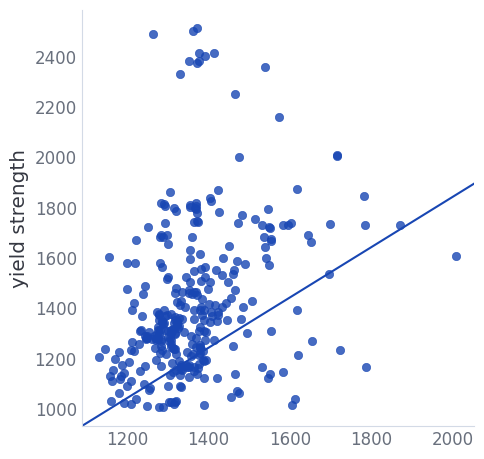

In [10]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR

feat_z = (feat_df - feat_df.mean()) / (feat_df.std() + 1e-12)
X = feat_z
feat_z_iqr = feat_z.agg(lambda x: np.quantile(x, 0.75) - np.quantile(x, 0.25))
X = X[feat_df.columns[feat_z_iqr > 0.5]]
# X = MinMaxScaler().fit_transform(feat_df)

y = df['yield strength']

reg = HistGradientBoostingRegressor(loss='absolute_error')
# reg = RandomForestRegressor(criterion='absolute_error')
# reg = SVR(kernel='linear', C=5)
# reg = SGDRegressor(loss='epsilon_insensitive', epsilon=0, alpha=1, validation_fraction=0.4)
reg = TransformedTargetRegressor(regressor=reg, inverse_func=lambda x: np.expm1(x + 7.5), func=lambda x: np.log1p(x) - 7.5)

yhat = cross_val_predict(reg, X, y)

print(np.mean(np.abs(yhat - y)))


sns.relplot(x=yhat, y=y, aspect=1, kind='scatter', ec=None, alpha=0.8)
plt.axline((0, 0), slope=1, transform=plt.gca().transAxes)

In [11]:
X.columns

Index(['MagpieData mean Number', 'MagpieData avg_dev Number',
       'MagpieData mean MendeleevNumber', 'MagpieData avg_dev MendeleevNumber',
       'MagpieData minimum MendeleevNumber', 'MagpieData mean AtomicWeight',
       'MagpieData avg_dev AtomicWeight', 'MagpieData mean MeltingT',
       'MagpieData avg_dev MeltingT', 'MagpieData mean Column',
       ...
       'Electronegativity local mismatch', 'VEC mean', 'Mixing enthalpy',
       'Mean cohesive energy', 'Interant electrons', 'Interant d electrons',
       'Shear modulus mean', 'Shear modulus delta',
       'Shear modulus local mismatch', 'Shear modulus strength model'],
      dtype='object', length=102)

In [ ]:
reg.fit(X, y)

TransformedTargetRegressor(func=<function <lambda> at 0x7ff17a5e67a0>,
                           inverse_func=<function <lambda> at 0x7ff17abd7a60>,
                           regressor=HistGradientBoostingRegressor(loss='absolute_error'))

In [ ]:
regressor = reg.regressor_ if hasattr(reg, 'regressor_') else reg
    
if hasattr(regressor, 'feature_importances_'):
    feat_imps = pd.Series(regressor.feature_importances_, index=feat_df.columns)
else:
    feat_imps = pd.Series(regressor.coef_, index=feat_df.columns)
feat_imps.sort_values(ascending=False).head(20)

AttributeError: 'HistGradientBoostingRegressor' object has no attribute 'coef_'

In [ ]:
feat_z = (feat_df - feat_df.mean()) / (feat_df.std() + 1e-12)

feat_z_iqr = feat_z.agg(lambda x: np.quantile(x, 0.75) - np.quantile(x, 0.25))

feat_z_iqr.sort_values().tail(50)

MagpieData avg_dev NValence               1.543212
MagpieData mean NdValence                 1.544254
Interant d electrons                      1.550459
MEGNetElementData mean embedding 16       1.561518
MEGNetElementData avg_dev embedding 5     1.575938
Configuration entropy                     1.578254
MEGNetElementData mean embedding 1        1.580262
Shear modulus mean                        1.583432
Miedema_deltaH_ss_min                     1.584367
MEGNetElementData avg_dev embedding 15    1.590520
MEGNetElementData avg_dev embedding 13    1.620893
MEGNetElementData mean embedding 15       1.621131
MagpieData mean GSmagmom                  1.626273
MagpieData mean GSbandgap                 1.646461
Yang delta                                1.647408
MEGNetElementData avg_dev embedding 2     1.657277
Shear modulus strength model              1.663692
MagpieData avg_dev GSbandgap              1.671088
MagpieData avg_dev CovalentRadius         1.671668
MEGNetElementData avg_dev embed

<Axes: ylabel='Proportion'>

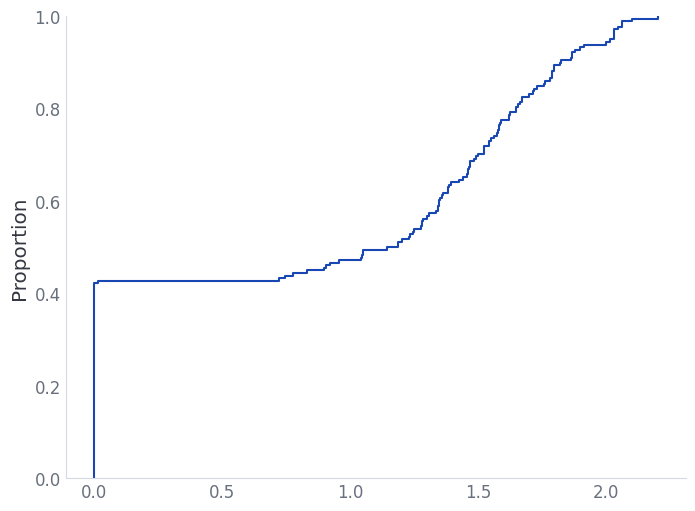

In [ ]:
sns.ecdfplot(feat_z_iqr)

In [21]:
from matbench.bench import MatbenchBenchmark
mb = MatbenchBenchmark(autoload=False, subset=["matbench_steels"])
for task in mb.tasks:
    task.load()
    for fold in task.folds:
        print(f'fold no: {fold}')
        train_inputs, train_outputs = task.get_train_and_val_data(fold)
        test_inputs = task.get_test_data(fold, include_target=False)

        print(train_inputs.shape, test_inputs.shape)

2024-05-10 17:20:24 INFO     Initialized benchmark 'matbench_v0.1' with 1 tasks: 
['matbench_steels']
2024-05-10 17:20:24 INFO     Loading dataset 'matbench_steels'...
2024-05-10 17:20:24 INFO     Dataset 'matbench_steels loaded.
fold no: 0
(249,) (63,)
fold no: 1
(249,) (63,)
fold no: 2
(250,) (62,)
fold no: 3
(250,) (62,)
fold no: 4
(250,) (62,)


In [24]:
!ls

basis.ipynb  LICENSE.txt	  mlp_benchmark.py  results.json     tests
datasets     matbench-split.py	  pyproject.toml    results.json.gz
kan.ipynb    mlp_benchmark.ipynb  README.md	    src


In [31]:
!cp results.json.gz results.json
import json

with open('results.json.gz', 'r') as infile:
    res = json.load(infile)

res

{'@module': 'matbench.bench',
 '@class': 'MatbenchBenchmark',
 'version': '0.6',
 'tasks': {'matbench_steels': {'@class': 'MatbenchTask',
   '@module': 'matbench.task',
   'benchmark_name': 'matbench_v0.1',
   'dataset_name': 'matbench_steels',
   'results': {'fold_0': {'data': {'mb-steels-003': 2295.7900390625,
      'mb-steels-005': 2384.316650390625,
      'mb-steels-020': 1165.160400390625,
      'mb-steels-026': 1300.9376220703125,
      'mb-steels-027': 1945.1185302734375,
      'mb-steels-032': 1641.2529296875,
      'mb-steels-035': 1314.1348876953125,
      'mb-steels-041': 1478.7708740234375,
      'mb-steels-045': 1432.813720703125,
      'mb-steels-046': 1307.634033203125,
      'mb-steels-064': 1183.9371337890625,
      'mb-steels-066': 1319.51318359375,
      'mb-steels-068': 1327.83837890625,
      'mb-steels-071': 1615.44677734375,
      'mb-steels-072': 1340.0908203125,
      'mb-steels-076': 1333.4573974609375,
      'mb-steels-077': 1393.18603515625,
      'mb-steels

In [12]:
feat_z = feat_z[feat_z.columns[feat_z_iqr > 1]].clip(-4, 4)
print(feat_z.shape)
feat_z['yield'] = df['yield strength']
feat_z.to_feather('datasets/steels_featurized.feather')

(312, 94)


In [14]:
'::'.join(feat_z.columns[:-1])

'MagpieData mean Number::MagpieData avg_dev Number::MagpieData mean MendeleevNumber::MagpieData minimum MendeleevNumber::MagpieData mean AtomicWeight::MagpieData avg_dev AtomicWeight::MagpieData mean MeltingT::MagpieData avg_dev MeltingT::MagpieData mean Column::MagpieData avg_dev Column::MagpieData minimum Column::MagpieData mean Row::MagpieData avg_dev Row::MagpieData mean CovalentRadius::MagpieData avg_dev CovalentRadius::MagpieData mean Electronegativity::MagpieData avg_dev Electronegativity::MagpieData minimum Electronegativity::MagpieData mean NsValence::MagpieData avg_dev NsValence::MagpieData mean NdValence::MagpieData avg_dev NdValence::MagpieData mean NValence::MagpieData avg_dev NValence::MagpieData mean NsUnfilled::MagpieData avg_dev NsUnfilled::MagpieData mean NdUnfilled::MagpieData avg_dev NdUnfilled::MagpieData maximum NdUnfilled::MagpieData mean NUnfilled::MagpieData avg_dev NUnfilled::MagpieData maximum NUnfilled::MagpieData mean GSbandgap::MagpieData avg_dev GSbandgap

In [ ]:
import matminer

from matminer.featurizers.base import MultipleFeaturizer
import matminer.featurizers.composition as cf

preset = cf.ElementProperty.from_preset('matscholar_el')
megnet = cf.ElementProperty.from_preset('megnet_el')

feats = MultipleFeaturizer([
    cf.ElementProperty(preset.data_source, preset.features, stats=['mean', 'avg_dev', 'minimum', 'maximum']),
    cf.ElementProperty(megnet.data_source, megnet.features, stats=['mean', 'avg_dev', 'minimum', 'maximum']),
    cf.Miedema(),
    cf.WenAlloys()   
])

feats

def featurize_data(df):
    feat_z = feat_z[feat_z.columns[feat_z_iqr > 1]].clip(-4, 4)
